## [식품 제조 공정에서의 불량 원인 규명 및 해결안 제안 - EDA]

### 분석용 데이터 설명 (불량률 원인 찾기, 공정능력분석 목표)
- Lot_ID : 제품 생산 Lot 번호 | 범주형 | L001, L002
- Line : 생산 라인 번호 | 범주형 | A, B, C
- Shift : 교대조 | 범주형 | 주간, 야간
- Operator : 작업자 ID | 범주형 | O1, O2, ... , O10
- Temp : 공정 온도(섭씨) | 연속형 | 22.5, 23.1, ...
- Humidity : 공정 습도(%) | 연속형 | 45, 47, 48, ...
- Weight : 제품 중량(g) | 연속형 | 99.5, 99.2, 100.2, ...
- Defect : 불량 여부 | 범주형 | 0 = 양품, 1 = 불량 
- Defect_Type : 불량 유형 | 범주형 | 중량초과, 포장불량, 양품, ...

### Gage R&R 데이터 설명(측정 시스템 신뢰성 검증 목표)
- Part : 제품 | P1 ~ P10 | 범주형
- Operator : 계측자(검사자) | O1 ~ O3 | 범주형
- Trial : 반복 시행 번호 | 1, 2 | 범주형
- Weight : 무게(g) | 100.1, 100.0, ... | 연속형

### 데이터에 따른 가설
1. 생산 라인에 따른 불량률에 대한 차이가 존재하는가?
2. 교대조에 따른 불량률에 대한 차이가 존재하는가?
3. 작업자에 따른 불량률 차이가 존재하는가?
4. 연속형 변수(공정 온도, 공정 습도, 제품 중량)간의 상관관계가 존재하는가?

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines # 선 그리기
import seaborn as sns
from scipy import stats
from statsmodels.stats.diagnostic import normal_ad
import statsmodels.formula.api as smf
import seaborn as sns

%precision 3
%matplotlib inline


import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/AppleGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='AppleGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'AppleGothic', 'axes.unicode_minus' : False}) # 폰트 설정, 마이너스 기호 깨짐 방지
plt.rc('font', family='AppleGothic')

import warnings
warnings.filterwarnings('ignore')

In [129]:
food = pd.read_csv('../data/food_clean+remove_outlier_modify.csv')
food

,Lot_ID,Line,Shift,Operator,Temp,Humidity,Defect,Defect_Type,Weight
0,L003,A,주간,O8,26.4,42.9,0,양품,100.190255
1,L029,B,주간,O2,24.3,57.7,0,양품,98.952307
2,L035,A,주간,O4,23.5,44.3,0,양품,99.997581
3,L018,A,야간,O9,26.5,44.4,0,양품,100.536753
4,L020,B,주간,O9,27.2,55.9,1,인쇄불량,98.838464
...,...,...,...,...,...,...,...,...,...
391,L046,A,야간,O2,23.1,58.1,0,양품,98.575073
392,L013,A,주간,O9,25.5,53.0,0,양품,100.031100
393,L027,A,주간,O5,24.2,46.3,0,양품,100.401429
394,L047,C,야간,O5,24.0,50.7,0,양품,99.249985


In [130]:
grr = pd.read_csv('../data/gage_rr_sample.csv')
grr.head()

,Part,Operator,Trial,Weight
0,P1,O1,1,100.26
1,P1,O1,2,100.26
2,P1,O2,1,100.30
3,P1,O2,2,99.87
4,P1,O3,1,99.80


In [131]:
food.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Lot_ID       396 non-null    object 
 1   Line         396 non-null    object 
 2   Shift        396 non-null    object 
 3   Operator     396 non-null    object 
 4   Temp         396 non-null    float64
 5   Humidity     396 non-null    float64
 6   Defect       396 non-null    int64  
 7   Defect_Type  396 non-null    object 
 8   Weight       396 non-null    float64
dtypes: float64(3), int64(1), object(5)
memory usage: 28.0+ KB


In [132]:
grr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Part      60 non-null     object 
 1   Operator  60 non-null     object 
 2   Trial     60 non-null     int64  
 3   Weight    60 non-null     float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.0+ KB


In [133]:
# 오류유형 (Defect Type)에 대한 요약표 작성
error_count1 = food['Defect_Type'].value_counts() # 빈도 요약
error_count1

Defect_Type
양품      363
인쇄불량     11
중량초과     10
포장불량      7
기타        5
Name: count, dtype: int64

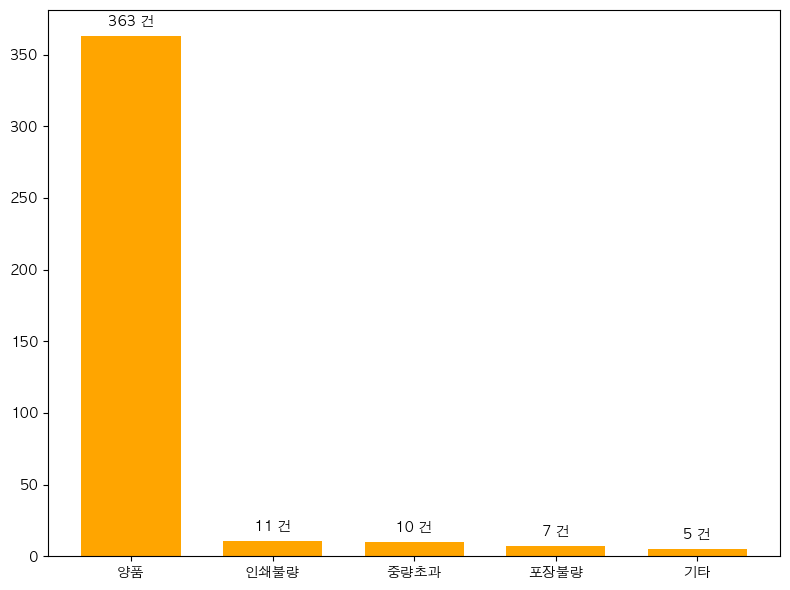

In [134]:
# 그래프 크기 설정하기
plt.figure(figsize = (8, 6))


error_count_plot1 = plt.bar(error_count1.index, error_count1.values, color = 'orange', width = 0.7)
# 빈도 추가하기
plt.bar_label(error_count_plot1, padding=5, fontsize=10, fmt='%d 건')

plt.tight_layout()
plt.show()

In [ ]:
# 범주형 데이터 요약
food.describe(include='object')

,Lot_ID,Line,Shift,Operator,Defect_Type
count,396,396,396,396,396
unique,50,3,2,10,5
top,L015,B,주간,O2,양품
freq,15,175,238,53,363


In [275]:
# 연속형 데이터 요약
food.describe(include='number')

,Temp,Humidity,Defect,Weight
count,396.000000,396.000000,396.000000,396.000000
mean,24.959596,49.917424,0.083333,99.993739
std,1.959084,4.704431,0.276735,0.877748
min,20.100000,39.900000,0.000000,97.392260
25%,23.600000,46.600000,0.000000,99.404233
50%,25.000000,49.800000,0.000000,100.006018
75%,26.300000,53.400000,0.000000,100.601005
max,29.300000,61.600000,1.000000,102.796165


In [135]:
# 기초 통계량 확인
food.loc[:, ["Temp", "Humidity", "Weight"]].describe()

,Temp,Humidity,Weight
count,396.000000,396.000000,396.000000
mean,24.959596,49.917424,99.993739
std,1.959084,4.704431,0.877748
min,20.100000,39.900000,97.392260
25%,23.600000,46.600000,99.404233
50%,25.000000,49.800000,100.006018
75%,26.300000,53.400000,100.601005
max,29.300000,61.600000,102.796165


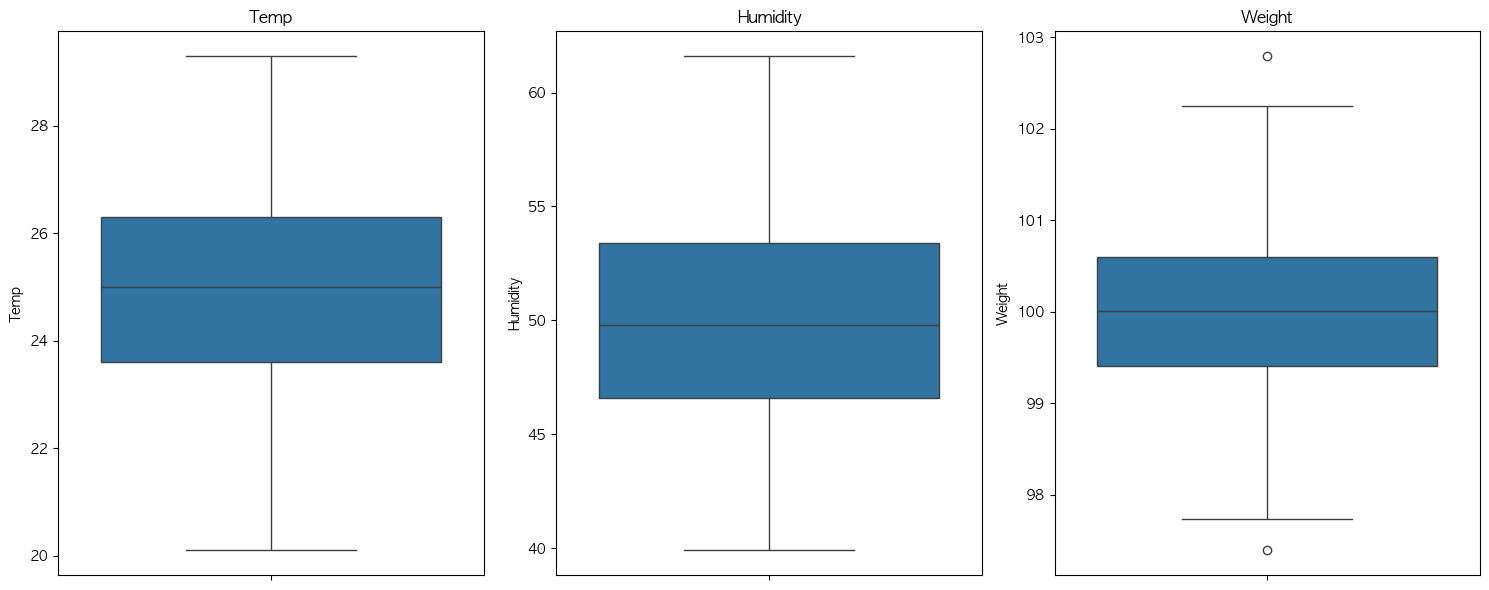

In [136]:
# 연속형 변수 baxplot 그리기
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
axes.flatten()

for i, col in enumerate(['Temp', 'Humidity', 'Weight']):
    axes[i].set_title(f'{col}')
    sns.boxplot(data=food, y=col, ax=axes[i])

plt.tight_layout()
plt.show()

### 가설1. 생산 라인에 따른 불량률에 대한 차이가 존재하는가?

In [190]:
line_error = food.groupby('Line')['Defect'].value_counts().reset_index()
line_error

,Line,Defect,count
0,A,0,133
1,A,1,13
2,B,0,160
3,B,1,15
4,C,0,70
5,C,1,5


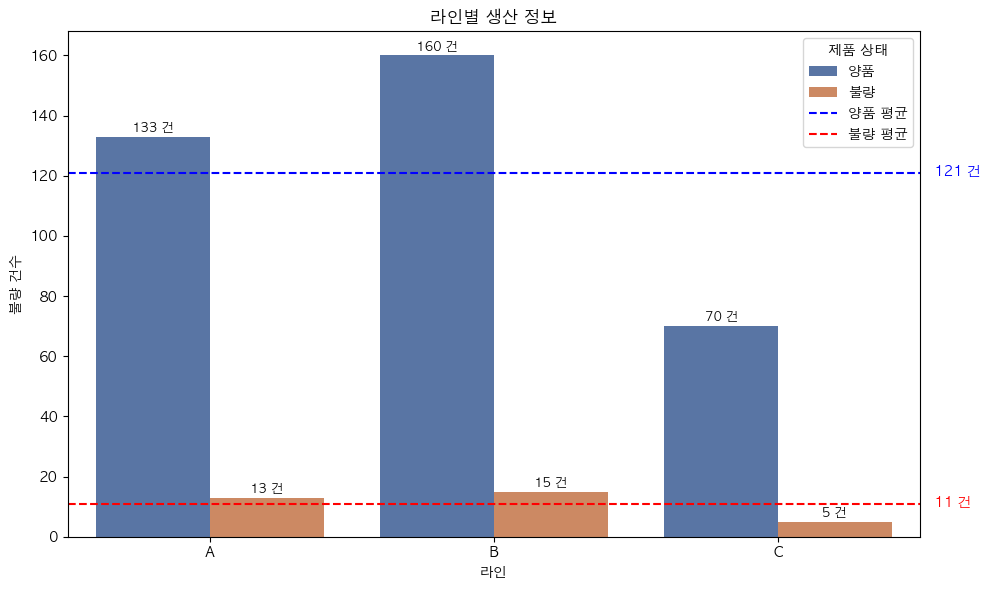

In [ ]:
plt.figure(figsize=(10, 6))

# barplot 그리기
line_bars1 = sns.barplot(line_error, x='Line', y='count', hue='Defect', palette='deep')

# 건 수 표시하기
for container in line_bars1.containers:
    labels = [f'{int(bar.get_height())} 건' if bar.get_height() > 0 else ''
              for bar in container]
    line_bars1.bar_label(container, labels=labels, padding=2, fontsize=9)


# legend 설정하기
legends = {0: '양품', 1: '불량'}
handles, labels = line_bars1.get_legend_handles_labels()
labels = [legends[int(label)] for label in labels]
line_bars1.legend(handles, labels, title='제품 상태', loc='upper right')

# 그래프 제목과 축 이름 설정하기
plt.title('라인 별 생산 정보')
plt.xlabel('라인')
plt.ylabel('불량 건수')

# 수평선 (평균선) 그리기
bad_mean = line_error.loc[line_error['Defect'] == 1, 'count'].mean()
good_mean = line_error.loc[line_error['Defect'] == 0, 'count'].mean()

plt.axhline(y=bad_mean, color='r', linestyle='--')
plt.text(2.55, int(bad_mean)-1, f'{int(bad_mean)} 건', color='r')
plt.axhline(y=good_mean, color='b', linestyle='--',)
plt.text(2.55, int(good_mean)-1, f'{int(good_mean)} 건', color='b')

# 수평선 범례용 Line2D 객체 생성
red_line = mlines.Line2D([], [], color='r', linestyle='--', label='불량 평균')
blue_line = mlines.Line2D([], [], color='b', linestyle='--', label='양품 평균')

# 기존 barplot 범례 + 수평선 범례 합치기
line_bars1.legend(handles + [blue_line, red_line],
             labels + ['양품 평균', '불량 평균'],
             title='제품 상태',
             loc='upper right')

plt.tight_layout()
plt.show()

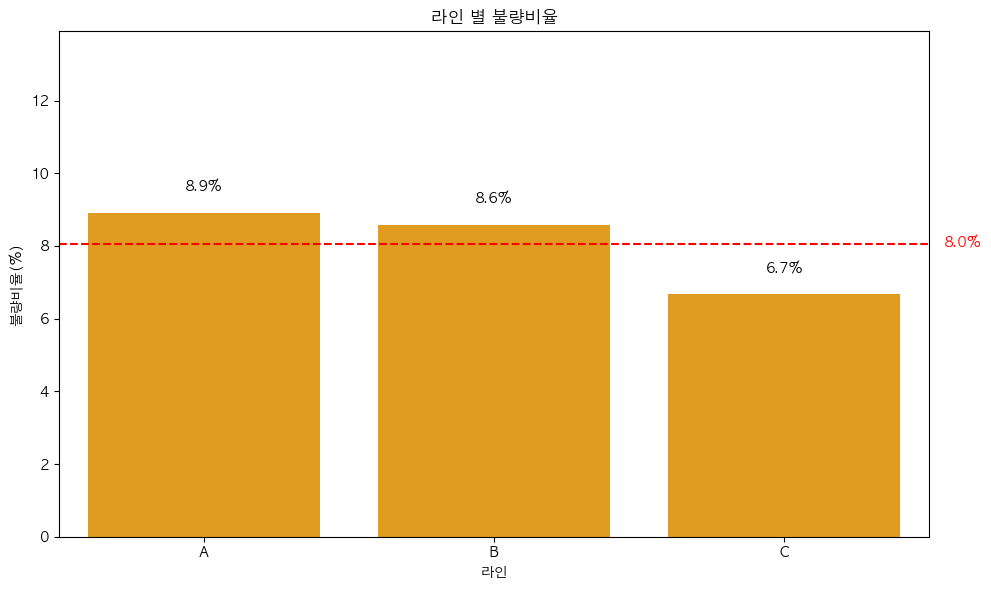

In [267]:
# pivot 형태로 변환
df_pivot = line_error.pivot(index="Line", columns="Defect", values="count")
df_pivot.columns = ["양품", "불량"]

# 불량비율 계산
df_pivot["불량비율(%)"] = df_pivot["불량"] / (df_pivot["양품"] + df_pivot["불량"]) * 100

# 평균 불량비율
mean_defect_rate = df_pivot["불량비율(%)"].mean()

# 시각화
plt.figure(figsize=(10,6))
ax = sns.barplot(data=df_pivot.reset_index(), x="Line", y="불량비율(%)", color="orange")

# bar 위에 수치 표시
for i, v in enumerate(df_pivot["불량비율(%)"]):
    ax.text(i, v + 0.5, f"{v:.1f}%", ha="center", va="bottom")

# 평균선 추가
plt.axhline(y=mean_defect_rate, color='red', linestyle='--', label=f'평균 {mean_defect_rate:.1f}%')
plt.text(len(df_pivot)-0.45, mean_defect_rate-0.1, f'{mean_defect_rate:.1f}%', color='red')

# 그래프 꾸미기
plt.title("라인 별 불량비율")
plt.ylabel("불량비율(%)")
plt.xlabel("라인")
plt.ylim(0, df_pivot["불량비율(%)"].max() + 5)

plt.tight_layout()
plt.show()

- 라인 별 생산 정보는 "B라인"이 가장 많다.
- 라인 별 불량비율을 확인했을 때 "C라인"이 확실히 불량 비율이 적은 경향이 존재한다.

#### 파생 가설

- C라인에서 불량 비율이 적은 이유가 무엇인가?
  - C라인에서 작업하는 특정 작업자가 존재하는가?
  - C라인에서 생산되는 주간/야간의 생산 건수 및 비율은 어떻게 되는가?
  - C라인에서 생산되는 생산환경(습도, 온도)는 어떤 경향을 보이는가? 또한 A와 B라인과 다른 경향이 존재하는가?

### 가설2. 교대조에 따른 불량률에 대한 차이가 존재하는가?

In [268]:
shift_error = food.groupby('Shift')['Defect'].value_counts().reset_index()
shift_error

,Shift,Defect,count
0,야간,0,141
1,야간,1,17
2,주간,0,222
3,주간,1,16


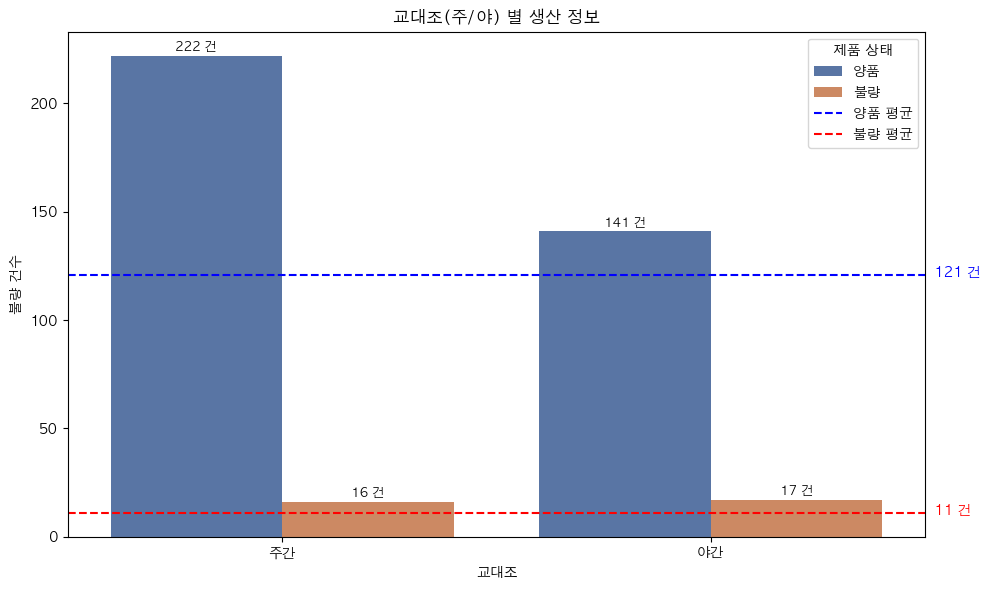

In [269]:
plt.figure(figsize=(10, 6))

# barplot 그리기
shift_bars1 = sns.barplot(shift_error, 
                          x='Shift', 
                          y='count', 
                          hue='Defect', 
                          order=["주간", "야간"], 
                          palette='deep')

# 건 수 표시하기
for container in shift_bars1.containers:
    labels = [f'{int(bar.get_height())} 건' if bar.get_height() > 0 else ''
              for bar in container]
    shift_bars1.bar_label(container, labels=labels, padding=2, fontsize=9)


# legend 설정하기
legends = {0: '양품', 1: '불량'}
handles, labels = shift_bars1.get_legend_handles_labels()
labels = [legends[int(label)] for label in labels]
shift_bars1.legend(handles, labels, title='제품 상태', loc='upper right')

# 그래프 제목과 축 이름 설정하기
plt.title('교대조(주/야) 별 생산 정보')
plt.xlabel('교대조')
plt.ylabel('불량 건수')

# 수평선 (평균선) 그리기
bad_mean = line_error.loc[line_error['Defect'] == 1, 'count'].mean()
good_mean = line_error.loc[line_error['Defect'] == 0, 'count'].mean()

plt.axhline(y=bad_mean, color='r', linestyle='--')
plt.text(1.52, int(bad_mean)-1, f'{int(bad_mean)} 건', color='r')
plt.axhline(y=good_mean, color='b', linestyle='--',)
plt.text(1.52, int(good_mean)-1, f'{int(good_mean)} 건', color='b')

# 수평선 범례용 Line2D 객체 생성
red_line = mlines.Line2D([], [], color='r', linestyle='--', label='불량 평균')
blue_line = mlines.Line2D([], [], color='b', linestyle='--', label='양품 평균')

# 기존 barplot 범례 + 수평선 범례 합치기
shift_bars1.legend(handles + [blue_line, red_line],
             labels + ['양품 평균', '불량 평균'],
             title='제품 상태',
             loc='upper right')

plt.tight_layout()
plt.show()

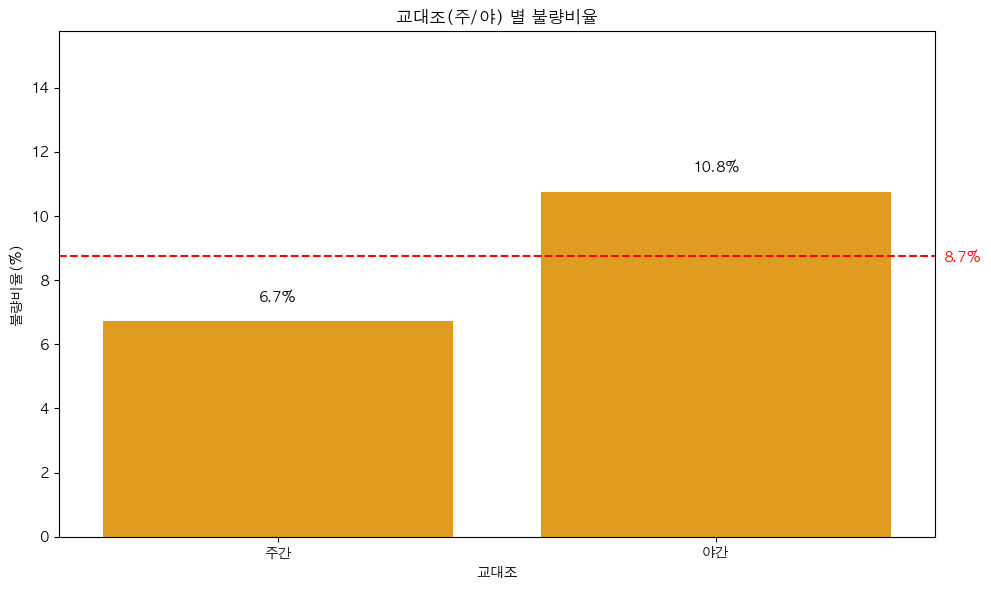

In [266]:
# pivot 형태로 변환
df_pivot = shift_error.pivot(index="Shift", columns="Defect", values="count").sort_index(ascending=False)
df_pivot.columns = ["양품", "불량"]

# 불량비율 계산
df_pivot["불량비율(%)"] = df_pivot["불량"] / (df_pivot["양품"] + df_pivot["불량"]) * 100

# 평균 불량비율
mean_defect_rate = df_pivot["불량비율(%)"].mean()

# 시각화
plt.figure(figsize=(10,6))
ax = sns.barplot(data=df_pivot.reset_index(), 
                 x="Shift", 
                 y="불량비율(%)", 
                 order=["주간", "야간"], 
                 color="orange")

# bar 위에 수치 표시
for i, v in enumerate(df_pivot["불량비율(%)"]):
    ax.text(i, v + 0.5, f"{v:.1f}%", ha="center", va="bottom")

# 👉 평균선 추가
plt.axhline(y=mean_defect_rate, color='red', linestyle='--', label=f'평균 {mean_defect_rate:.1f}%')
plt.text(len(df_pivot)-0.48, mean_defect_rate-0.2, f'{mean_defect_rate:.1f}%', color='red')

# 그래프 꾸미기
plt.title("교대조(주/야) 별 불량비율")
plt.ylabel("불량비율(%)")
plt.xlabel("교대조")
plt.ylim(0, df_pivot["불량비율(%)"].max() + 5)

plt.tight_layout()
plt.show()

- 교대조(주/야) 별 생산 정보는 "주간"이 더 많다.
- 주간/야간 모두 건수로 따지면 비슷한 건수의 불량이 발생했지만, **야간 총 생산량이 적으므로 야간의 불량비율이 더 높다.**

#### 파생 가설
- 주/야의 작업자 차이가 존재하는가?
- 주간이나 야간에만 사용하는 라인이 존재하는가?
- 주간과 야간의 생산환경(습도, 온도)는 어떠한가? 또한 주/야간 사이의 서로다른 경향이 존재하는가?

### 가설3. 작업자에 따른 불량률 차이가 존재하는가?

In [137]:
operator_error = food.groupby('Operator')['Defect'].value_counts().reset_index()
operator_error = operator_error.sort_values(by='Operator', key = lambda x: x.str.replace('O', '').astype(int))
operator_error.reset_index(drop=True, inplace=True)
operator_error

,Operator,Defect,count
0,O1,0,38
1,O1,1,4
2,O2,0,49
3,O2,1,4
4,O3,1,1
5,O3,0,32
6,O4,0,39
7,O4,1,5
8,O5,0,41
9,O5,1,1


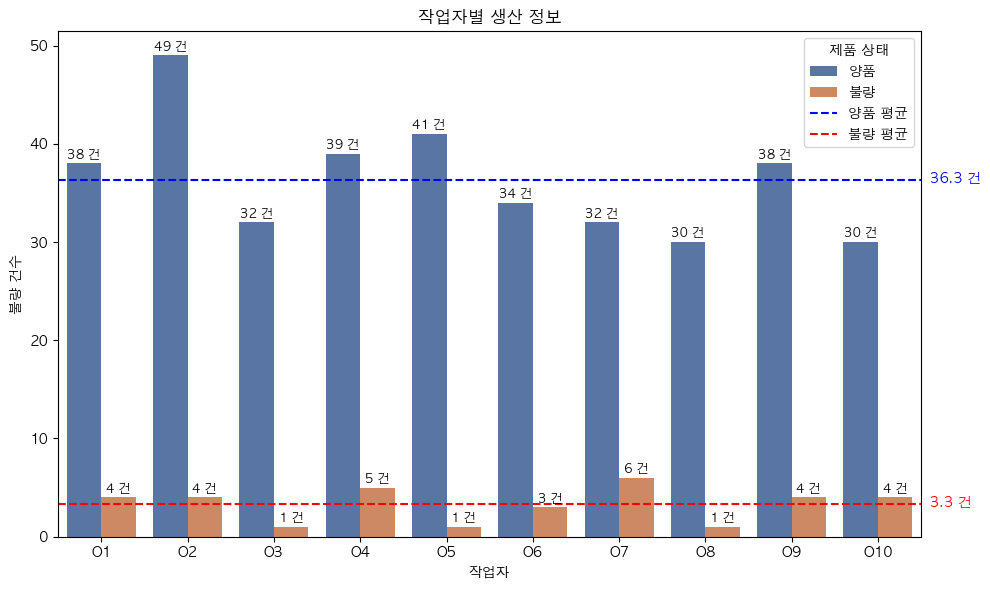

In [187]:
plt.figure(figsize=(10, 6))

# barplot 그리기
bars1 = sns.barplot(operator_error, x='Operator', y='count', hue='Defect', palette='deep')

# 건 수 표시하기
for container in bars1.containers:
    labels = [f'{int(bar.get_height())} 건' if bar.get_height() > 0 else ''
              for bar in container]
    bars1.bar_label(container, labels=labels, padding=2, fontsize=9)


# legend 설정하기
legends = {0: '양품', 1: '불량'}
handles, labels = bars1.get_legend_handles_labels()
labels = [legends[int(label)] for label in labels]
bars1.legend(handles, labels, title='제품 상태', loc='upper right')

# 그래프 제목과 축 이름 설정하기
plt.title('작업자별 생산 정보')
plt.xlabel('작업자')
plt.ylabel('불량 건수')

# 수평선 (평균선) 그리기
bad_mean = operator_error.loc[operator_error['Defect'] == 1, 'count'].mean()
good_mean = operator_error.loc[operator_error['Defect'] == 0, 'count'].mean()

plt.axhline(y=bad_mean, color='r', linestyle='--')
plt.text(9.6, int(bad_mean), f'{bad_mean:.1f} 건', color='r')
plt.axhline(y=good_mean, color='b', linestyle='--',)
plt.text(9.6, int(good_mean), f'{good_mean:.1f} 건', color='b')

# 수평선 범례용 Line2D 객체 생성
red_line = mlines.Line2D([], [], color='r', linestyle='--', label='불량 평균')
blue_line = mlines.Line2D([], [], color='b', linestyle='--', label='양품 평균')

# 기존 barplot 범례 + 수평선 범례 합치기
bars1.legend(handles + [blue_line, red_line],
             labels + ['양품 평균', '불량 평균'],
             title='제품 상태',
             loc='upper right')

plt.tight_layout()
plt.show()

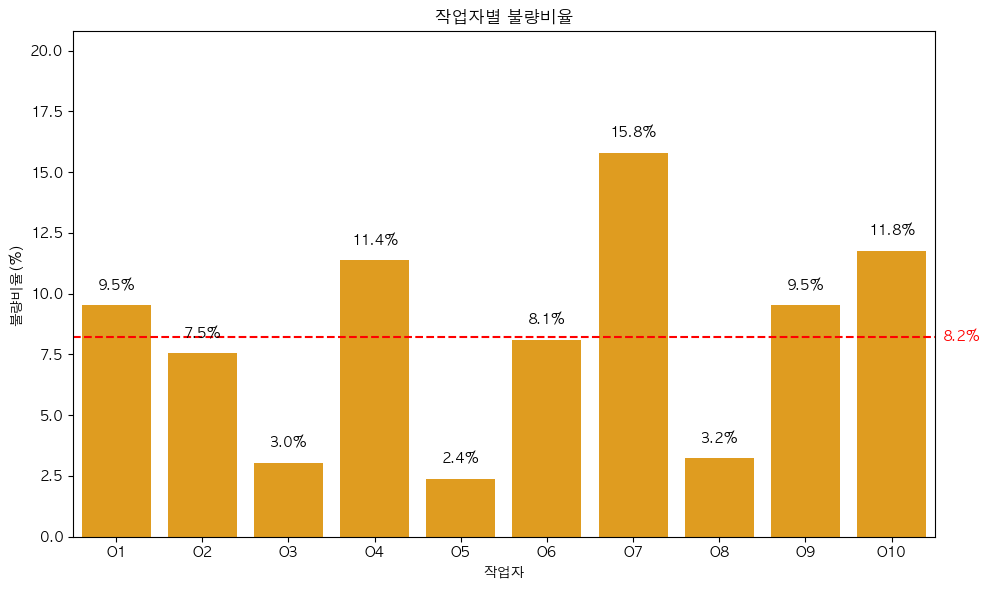

In [188]:
# pivot 형태로 변환
df_pivot = operator_error.pivot(index="Operator", columns="Defect", values="count") \
    .sort_index(key = lambda x: x.str.replace('O', '').astype(int)).fillna(0)
df_pivot.columns = ["양품", "불량"]

# 불량비율 계산
df_pivot["불량비율(%)"] = df_pivot["불량"] / (df_pivot["양품"] + df_pivot["불량"]) * 100

# 평균 불량비율
mean_defect_rate = df_pivot["불량비율(%)"].mean()

# 시각화
plt.figure(figsize=(10,6))
ax = sns.barplot(data=df_pivot.reset_index(), x="Operator", y="불량비율(%)", color="orange")

# bar 위에 수치 표시
for i, v in enumerate(df_pivot["불량비율(%)"]):
    ax.text(i, v + 0.5, f"{v:.1f}%", ha="center", va="bottom")

# 👉 평균선 추가
plt.axhline(y=mean_defect_rate, color='red', linestyle='--', label=f'평균 {mean_defect_rate:.1f}%')
plt.text(len(df_pivot)-0.4, mean_defect_rate-0.2, f'{mean_defect_rate:.1f}%', color='red')

# 그래프 꾸미기
plt.title("작업자별 불량비율")
plt.ylabel("불량비율(%)")
plt.xlabel("작업자")
plt.ylim(0, df_pivot["불량비율(%)"].max() + 5)

plt.tight_layout()
plt.show()

- 작업자 별 생산 건수는 크게 차이 없으나 "O2" 작업자의 생산 건수가 다른 작업자에 비해서 많은 것을 알 수 있다.
- 각 작업자 별 불량 비율을 확인했을 때 "O7" 작업자가 가장 큰 불량률을 보였으며, "O10", "O4" 작업자 또한 큰 불량률을 보이고 있다.

#### 파생가설
- 작업자 간의 교육수준은 어떻게 되는가? (검토 불가)
- 작업자 별 작업간 공정수칙을 준수하고 있는가? (검토 불가)

### 가설4. 연속형 변수(공정 온도, 공정 습도, 제품 중량)간의 상관관계가 존재하는가?

In [283]:
numerical = food.loc[:, ["Temp", "Humidity", "Weight"]]
numerical.head()

,Temp,Humidity,Weight
0,26.4,42.9,100.190255
1,24.3,57.7,98.952307
2,23.5,44.3,99.997581
3,26.5,44.4,100.536753
4,27.2,55.9,98.838464


In [285]:
numerical_corr = numerical.corr()
numerical_corr

,Temp,Humidity,Weight
Temp,1.000000,0.07569,0.598687
Humidity,0.075690,1.00000,-0.542660
Weight,0.598687,-0.54266,1.000000


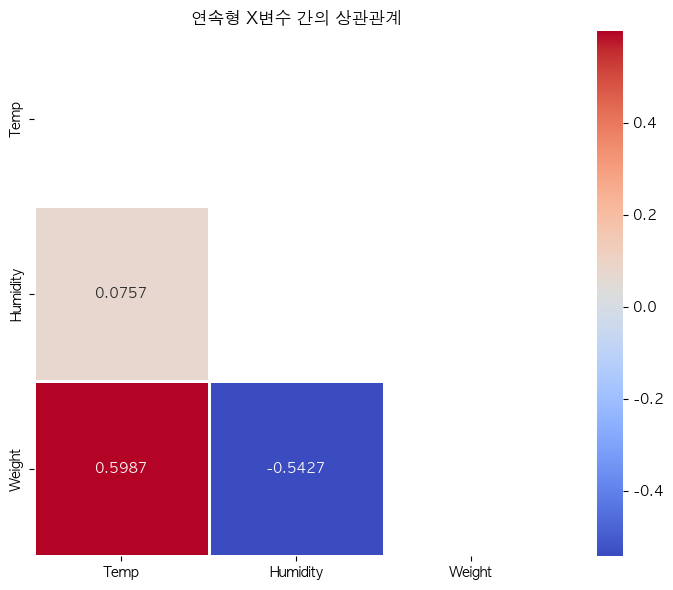

In [300]:
plt.figure(figsize = (8,6))
mask = np.triu(np.ones_like(numerical_corr, dtype=bool))
sns.heatmap(numerical_corr, annot=True, fmt=".4f", linewidths=2, mask=mask, cmap='coolwarm', square=True)
plt.title('연속형 X변수 간의 상관관계')
plt.tight_layout()
plt.show()

<Figure size 600x400 with 0 Axes>

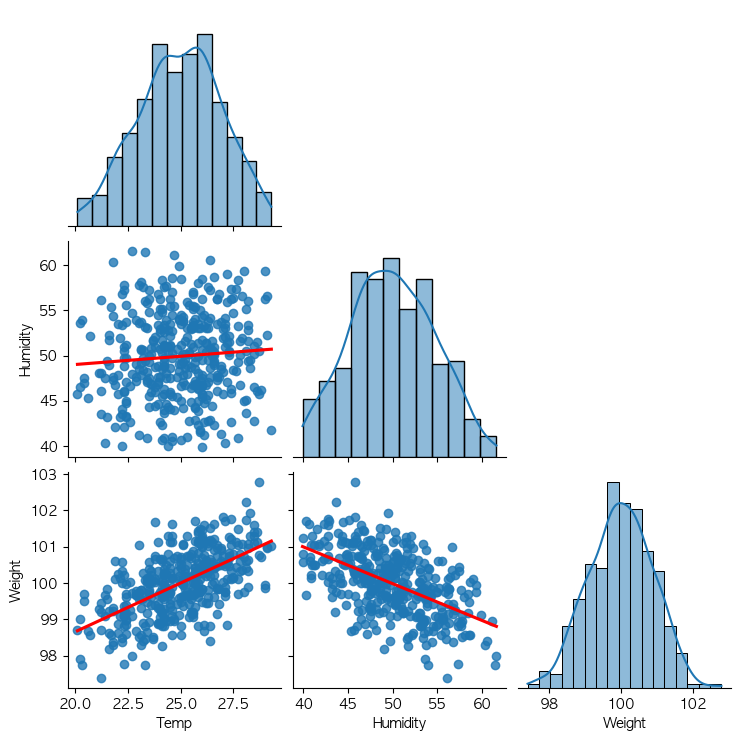

In [311]:
plt.figure(figsize=(6,4))
sns.pairplot(
    numerical,
    kind="reg",
    diag_kind="hist",
    plot_kws={'ci': None, 'line_kws': {'color': 'red'}},
    diag_kws={'kde': True},
    corner=True
)
plt.show()

- 상관계수를 통해 분석해보았을 때 Temp(온도) - Weight(무게)관계에서 양의 상관관계가 보이며, Humidity(습도) - Weight(무게)관계에서는 음의 상관관계가 보인다.
- X 변수인 Temp(온도) - Weight(무게)관계에서는 상관관계가 거의 없는 것으로 보인다 따라서 독립성을 유지하고 있다고 판단 할 수 있을 것 같다.